# Cylindrical Nanowire Functions
I will use this notebook to model a cylindrical nanowire with $N_\phi$ points in $\phi$ direction and $N_z$ points along the z direction.

- BdG Hamiltonian will be used to incorporate superconductivity.

- An axial magnetic field will be assumed.

- Spin-orbit coupling and Zeeman splitting will be neglected.

In [418]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import itertools
import scipy.optimize
from numpy.linalg import LinAlgError

# Define the Hamiltonian
The Hamiltonian will be a matrix of size $N_\phi N_z \times N_\phi N_z$. The order parameter and the chemical potential will be assumed to be constant in this region.

In [419]:
def calc_Hamiltonian(params):
    '''
    params is a dict with the following paramters:
    N_z   : number of points in z 
    N_phi : number of points in azimuthal direction
    t_z   : hopping paramter along z = hbar**2/(2 m a**2) where a is lattice spacing
    t_phi : hopping paramter along phi = hbar**2/(2 m a_phi**2) where a_phi is lattice spacing along 
            azimuthal direction 
    Delta : order paramter (complex number)
    mu    : chemical potential
    flux  : flux in units of h/e
    '''
    N_z = params['N_z'] 
    N_phi = params['N_phi'] 
    t_z = params['t_z']
    t_phi = params['t_phi']
    Delta = params['Delta']
    mu = params['mu']
    flux = params['flux']
    
    def matrix_ele(e1,e2):
        '''
        Returns the matrix element between points e1 and e2
        '''
        (z1,phi1) = e1
        (z2,phi2) = e2
        # onsite element
        if z1 == z2 and phi1 == phi2:
            if N_phi != 1:
                diag_ele = 2*t_z + np.abs(t_phi)*(2 - (2*np.pi*flux/N_phi)**2) - mu
            else:
                # diagonal elemenet for N_phi = 1 does not make sense
                diag_ele = 2*t_z - mu
            return np.array([[diag_ele,Delta],[np.conj(Delta),-np.conj(diag_ele)]])
        # z hopping
        elif abs(z1-z2) == 1 and phi1 == phi2:
            return np.array([[-t_z,0],[0,t_z]])
        # phi hopping
        elif (phi1-phi2 == 1 or phi1-phi2 == N_phi-1)and z1 == z2:
            return np.array([[-t_phi,0],[0,np.conj(t_phi)]])
        elif (phi1-phi2 == -1 or phi1-phi2 == -N_phi+1)and z1 == z2:
            return np.conj(np.array([[-t_phi,0],[0,np.conj(t_phi)]])).T
        else:
            return np.array([[0,0],[0,0]])
        
    # the basis is given by (n_z,n_phi) where n_z = 0,..,N_z-1, n_phi = 0,...,N_phi-1
    basis = list(itertools.product(range(N_z),range(N_phi)))
    H = [matrix_ele(e1,e2) for e1 in basis for e2 in basis]
    N = N_phi*N_z

    H_ar = np.array(H,dtype=np.complex64).reshape((N,N,2,2))
    
    # magic to flatten the Hamiltonian
    # Are you wathing closely?
    H_mat = np.array([H_ar[x,:,y,:].flatten() for x in range(H_ar.shape[0]) for y in range(H_ar.shape[2])])\
    .flatten().reshape(2*N,2*N)

    return H_mat

In [420]:
# test of the Hamiltonian function
params = {
    "N_z" : 2,
    "N_phi" : 4,
    "flux" : 0e0,
    "t_z" : 5e-3,
    "Delta" : 1e-3,
    "mu" : 10e-3,
}

params["t_phi"] = 51e-3*np.exp(1j*2*np.pi*params["flux"]/params["N_phi"])

H = calc_Hamiltonian(params)

# Density of States Calculation
I will define a function to calculate the density of states given a Hamiltonian.

In [362]:
def calc_dos(E,params):
    '''
    Returns the density of states for the Hamiltonian H for energies E
    '''
    H = calc_Hamiltonian(params)
    
    eta = params['eta']
    G = np.linalg.inv((E + 1j*eta).reshape(-1,1,1)*np.eye(H.shape[0]).reshape(1,H.shape[0],H.shape[1]) - H)
    A = 1j*(G - np.transpose(np.conj(G),(0,2,1)))
    # casting to real done to avoid problems later with plotting
    a = np.real(np.trace(A,axis1=-1,axis2=-2))
    return a

In [421]:
params = {
    "N_z" : 10,
    "N_phi" : 2,
    "flux" : 0e0,
    "t_z" : 50e-3,
    "Delta" : 1e-3,
    "mu" : 10e-3,
}

params["t_phi"] = 50e-3*np.exp(1j*2*np.pi*params["flux"]/params["N_phi"])

E_vec = np.linspace(-params['mu'],params['mu'],100)
eta = 1*(E_vec[1] - E_vec[0])
params['eta'] = eta
dos_vec = calc_dos(E_vec,params)

E_vec_gap = np.linspace(-2*params['Delta'],2*params['Delta'],100)
eta = 1*(E_vec_gap[1] - E_vec_gap[0])
params['eta'] = eta
dos_vec_gap = calc_dos(E_vec_gap,params)

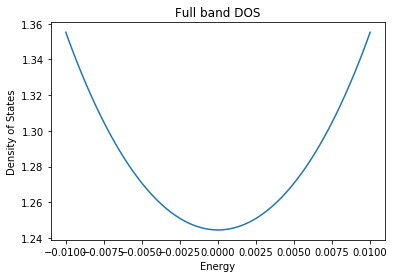

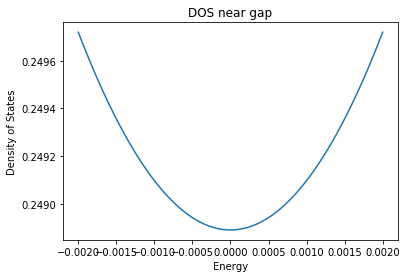

In [422]:
plt.figure(1)
plt.plot(E_vec,dos_vec)
plt.xlabel('Energy')
plt.ylabel('Density of States')
plt.title("Full band DOS")
plt.figure(2)
plt.plot(E_vec_gap,dos_vec_gap)
plt.xlabel('Energy')
plt.ylabel('Density of States')
plt.title("DOS near gap")

# Effect of changing $\mu$

In [423]:
mu_vec = np.linspace(0,400e-3,50)
# the range has to set to maximum of mu possible
# to see all dos
E_vec = np.linspace(-200e-3,200e-3,500)
E_vec_gap = np.linspace(-2*params['Delta'],2*params['Delta'],100)

dos_array = []
dos_gap_array = []
for mu in mu_vec:
    print(mu)
    params['mu'] = mu
    
    eta = 1*(E_vec[1] - E_vec[0])
    params['eta'] = eta
    dos_vec = calc_dos(E_vec,params)
    dos_array.append(dos_vec)
    
    eta = 1*(E_vec_gap[1] - E_vec_gap[0])
    params['eta'] = eta
    dos_vec_gap = calc_dos(E_vec_gap,params)
    dos_gap_array.append(dos_vec_gap)

0.0
0.00816326530612
0.0163265306122
0.0244897959184
0.0326530612245
0.0408163265306
0.0489795918367
0.0571428571429
0.065306122449
0.0734693877551
0.0816326530612
0.0897959183673
0.0979591836735
0.10612244898
0.114285714286
0.122448979592
0.130612244898
0.138775510204
0.14693877551
0.155102040816
0.163265306122
0.171428571429
0.179591836735
0.187755102041
0.195918367347
0.204081632653
0.212244897959
0.220408163265
0.228571428571
0.236734693878
0.244897959184
0.25306122449
0.261224489796
0.269387755102
0.277551020408
0.285714285714
0.29387755102
0.302040816327
0.310204081633
0.318367346939
0.326530612245
0.334693877551
0.342857142857
0.351020408163
0.359183673469
0.367346938776
0.375510204082
0.383673469388
0.391836734694
0.4


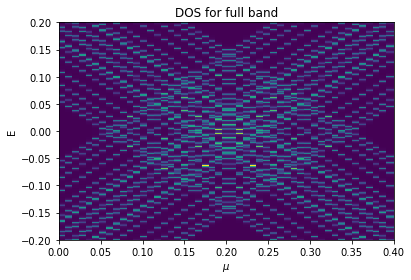

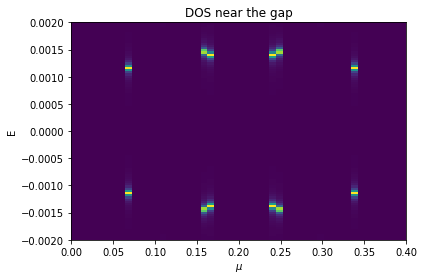

In [424]:
plt.figure(1)
XX,YY = np.meshgrid(mu_vec,E_vec)
plt.pcolor(XX,YY,np.array(dos_array).T)
plt.xlabel("$\mu$")
plt.ylabel("E")
plt.title("DOS for full band")

plt.figure(2)
XX,YY = np.meshgrid(mu_vec,E_vec_gap)
plt.pcolor(XX,YY,np.array(dos_gap_array).T)
plt.xlabel("$\mu$")
plt.ylabel("E")
plt.title("DOS near the gap")

# Density of States Calculation (semi-infinite)
I will calculate the surface density of states for a semi-infinite contact.

In [387]:
def calc_surface_g(E,params,eps = 1e-8,max_iter=100000,kappa=0.5):
    '''
    Return the surface Green's function at energy E 
    eta is used to calculated the Green's function
    eps controls the accuracy
    '''
    # conv here to avoid problems later
    E = np.array(E)
    
    H = calc_Hamiltonian(params)   
    eta = params['eta']
    surface_dof = 2*params['N_phi']
    alpha = H[:surface_dof,:surface_dof]
    beta = H[:surface_dof,surface_dof:2*surface_dof]
    
    def func_g(g,E,alpha,beta,eta):
        return np.linalg.inv((E + 1j*eta).reshape(-1,1,1)*np.eye(alpha.shape[0])- alpha - beta @ g @ np.conj(beta).T)
   
    g0 = np.zeros((len(E),alpha.shape[0],alpha.shape[1]))
    g = np.zeros((len(E),alpha.shape[0],alpha.shape[1]))
    
    err_vec = []
    for i in range(max_iter):
        g = func_g(g,E,alpha,beta,eta)
        g = ((1-kappa)*g + kappa*g0)
        err = np.linalg.norm(g - g0)/len(E)
        err_vec.append(err)
        g0 = np.copy(g)
        if err < eps:
            break
    return g

def calc_surface_dos(E,params):
    '''
    Calculates the desnity of states using the surface green's function
    '''
    g = calc_surface_g(E,params,eta)
    
    a = 1j*(g - np.transpose(np.conj(g),(0,2,1)))
    dos = np.real(np.trace(a,axis1=-1,axis2=-2))
    return dos 

In [415]:
params = {
    "N_z" : 10,
    "N_phi" : 1,
    "flux" : 0e0,
    "t_z" : 100e-3,
    "Delta" : 1e-3,
    "mu" : 10e-3,
}

params["t_phi"] = 50e-3*np.exp(1j*2*np.pi*params["flux"]/params["N_phi"])

E_vec = np.linspace(-params['mu'],params['mu'],100)
eta = 0.1*(E_vec[1] - E_vec[0])
params['eta'] = eta
dos_vec = calc_surface_dos(E_vec,params)

E_vec_gap = np.linspace(-2*params['Delta'],2*params['Delta'],100)
eta = 0.1*(E_vec_gap[1] - E_vec_gap[0])
params['eta'] = eta
dos_vec_gap = calc_surface_dos(E_vec_gap,params)

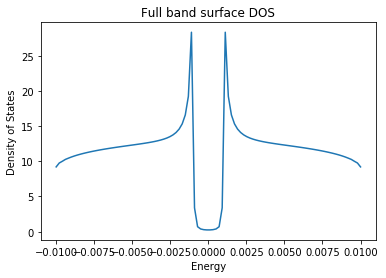

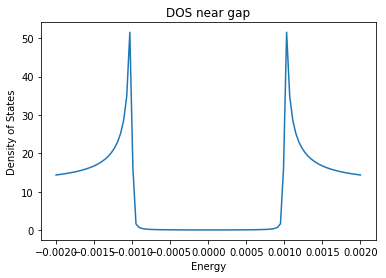

In [416]:
plt.figure(1)
plt.plot(E_vec,dos_vec)
plt.xlabel('Energy')
plt.ylabel('Density of States')
plt.title("Full band surface DOS")
plt.figure(2)
plt.plot(E_vec_gap,dos_vec_gap)
plt.xlabel('Energy')
plt.ylabel('Density of States')
plt.title("DOS near gap")

## Study of surface DOS with cross-section as a function of $\mu$

In [413]:
mu_vec = np.linspace(0e-3,400e-3,50)
# the range has to set to maximum of mu possible
# to see all dos
E_vec = np.linspace(-400e-3,400e-3,100)
E_vec_gap = np.linspace(-2*params['Delta'],2*params['Delta'],100)

dos_array = []
dos_gap_array = []
for mu in mu_vec:
    params['mu'] = mu
    
    eta = 1*(E_vec[1] - E_vec[0])
    params['eta'] = eta
    dos_vec = calc_surface_dos(E_vec,params)
    dos_array.append(dos_vec)
    
    eta = 0.1*(E_vec_gap[1] - E_vec_gap[0])
    params['eta'] = eta
    dos_vec_gap = calc_surface_dos(E_vec_gap,params)
    dos_gap_array.append(dos_vec_gap)

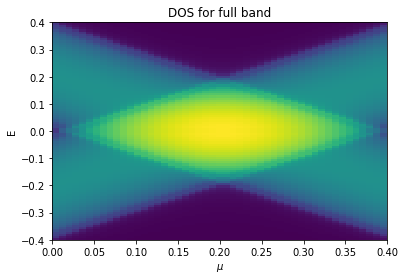

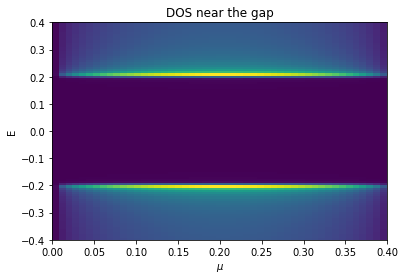

In [414]:
plt.figure(1)
XX,YY = np.meshgrid(mu_vec,E_vec)
plt.pcolor(XX,YY,np.array(dos_array).T)
plt.xlabel("$\mu$")
plt.ylabel("E")
plt.title("DOS for full band")
plt.figure(2)
XX,YY = np.meshgrid(mu_vec,E_vec)
plt.pcolor(XX,YY,np.array(dos_gap_array).T)
plt.xlabel("$\mu$")
plt.ylabel("E")
plt.title("DOS near the gap")

## SNS device DOS
Now, I will use the code to model a SNS device, with semi-infinite superconducting regions. I want to look at the density of states.

In [434]:
def calc_sns_dos(E,params):
    '''
    Returns the density of states for a SNS device
    '''
    eta = params['eta']
    N_z = params['N_z']
    N_phi = params['N_phi']
    mu_N = params['mu_N']
    mu_S1 = params['mu_S1']
    mu_S2 = params['mu_S2']
    flux = params['flux']
    
    N_params = {
        'N_z' : N_z,
        'N_phi' : N_phi,
        'Delta' : 0,
        'mu' : mu_N,
        't_z' : params['t_z'],
        't_phi' : params['t_phi'],
        'flux' : flux,
        'eta' : eta,
    }
    S1_params = {
        'N_z' : 2,
        'N_phi' : N_phi,
        'Delta' : params['Delta_S1'],
        'mu' : mu_S1,
        't_z' : params['t_z'],
        't_phi' : params['t_phi'],
        'flux' : flux,
        'eta' : eta,
    }
    S2_params = {
        'N_z' : 2,
        'N_phi' : N_phi,
        'Delta' : params['Delta_S2'],
        'mu' : mu_S2,
        't_z' : params['t_z'],
        't_phi' : params['t_phi'],
        'flux' : flux,
        'eta' : eta,
    }

    g_1 = calc_surface_g(E,S1_params,eta)
    g_2 = calc_surface_g(E,S2_params,eta)
    
    H_mat = calc_Hamiltonian(N_params)
   
    #number of dof in a layer
    N_dof_lat = N_phi*2
    # the hopping element between layers
    beta_layer = H_mat[:N_dof_lat,N_dof_lat:2*N_dof_lat]
    
    # the only non-zero elements in sigma
    sigma_mini_1 = np.conj(np.transpose(beta_layer[np.newaxis,:,:],(0,2,1)))@g_1@beta_layer
    sigma_mini_2 = np.conj(np.transpose(beta_layer[np.newaxis,:,:],(0,2,1)))@g_2@beta_layer
    
    sigma_1 = np.zeros((len(E),H_mat.shape[0],H_mat.shape[1]),dtype=np.complex64)
    sigma_1[:,:N_dof_lat,:N_dof_lat] = sigma_mini_1
    
    sigma_2 = np.zeros((len(E),H_mat.shape[0],H_mat.shape[1]),dtype=np.complex64)
    sigma_2[:,-N_dof_lat:,-N_dof_lat:] = sigma_mini_2
    
    G = np.linalg.inv((E + 1j*eta).reshape(-1,1,1)*np.eye(H_mat.shape[0]) - H_mat - sigma_1 - sigma_2)
    
    A = 1j*(G - np.transpose(np.conj(G),(0,2,1)))
    
    return np.real(np.trace(A,axis1=-1,axis2=-2))

In [504]:
# phase diff between S1 and S2
phi = np.pi/4
params = {
    'N_z' : 10,
    'N_phi' : 4,
    'flux' : 0.2e0,
    't_z' : 100e-3,
    'Delta_S1' : 1e-3,
    'Delta_S2' : 1e-3*np.exp(1j*phi),
    'mu_N' : 20e-3,
    'mu_S1' : 20e-3,
    'mu_S2' : 20e-3,
}

params['t_phi'] = 5e-3*np.exp(1j*2*np.pi*params['flux']/params['N_phi'])

E_vec = np.linspace(-params['mu_N'],params['mu_N'],100)
eta = 0.1*(E_vec[1] - E_vec[0])

params['eta'] = eta
dos_vec = calc_sns_dos(E_vec,params)

E_vec_gap = np.linspace(-2*params['Delta_S1'],2*params['Delta_S1'],100)
eta = 0.1*(E_vec_gap[1] - E_vec_gap[0])
params['eta'] = eta
dos_vec_gap = calc_sns_dos(E_vec_gap,params)

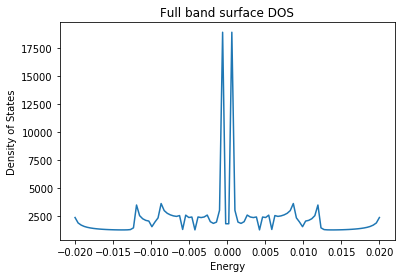

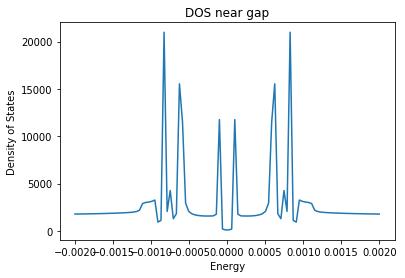

In [505]:
plt.figure(1)
plt.plot(E_vec,dos_vec)
plt.xlabel('Energy')
plt.ylabel('Density of States')
plt.title("Full band surface DOS")
plt.figure(2)
plt.plot(E_vec_gap,dos_vec_gap)
plt.xlabel('Energy')
plt.ylabel('Density of States')
plt.title("DOS near gap")

### ABS vs phase
I will look at how the dos evolve when the phase different is changed.

In [ ]:
phi_vec = np.linspace(0,2*np.pi,100)

E_vec_gap = np.linspace(-2*params['Delta_S1'],2*params['Delta_S1'],100)
eta = 1*(E_vec_gap[1] - E_vec_gap[0])
params['eta'] = eta

dos_array = []
for phi in phi_vec:
    params['Delta_S2'] = 1e-3*np.exp(1j*phi) 
    dos_array.append(calc_sns_dos(E_vec_gap,params))
dos_array = np.array(dos_array)

In [ ]:
XX,YY = np.meshgrid(phi_vec,E_vec_gap)
plt.pcolor(XX,YY,dos_array.T)
plt.xlabel(r"$\phi$")
plt.ylabel(r"Energy")